<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_traffic_sign

# Introduction

[Classification](https://towardsdatascience.com/machine-learning-classifiers-a5cc4e1b0623) is the process of predicting the class of given data points.

- An easy to understand example is classifying emails as “spam” or “not spam.”
- In machine learning an algorithm learns how to assign a class label to examples from a problem domain.
- Classification belongs to the category of supervised learning where the targets also provided with the input data.

# Traffic Sign Recognition Classifier

## Imports

In [1]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [3]:
! pip install opencv-python
! pip install scikit-image
! pip install arviz

In [4]:
from scipy.io import loadmat
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
%matplotlib inline
import pymc3 as pm
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
import random
import pickle
import arviz as az
import theano as tt
import cv2
from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle
from skimage.color import rgb2gray
import numpy as np

## Dataset


In [5]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. [Download the dataset](https://d17h27t6h515a5.cloudfront.net/topher/2016/November/581faac4_traffic-signs-data/traffic-signs-data.zip). This is a pickled dataset with size 
32x32 images.

2. Upload the dataset into your folder.

How to upload data to google colab: [here.](https://www.youtube.com/watch?v=-1jFfadz7bo)

At the right hand of this notebook you will find 4 icons:
<div>
<img src="https://drive.google.com/uc?export=view&id=1G-nwwqYv-KeLFuBkIbVgw_fiNm9RhluK" width="250"/>
</div>

Follow this steps:
* click on the folder icon
* choose one of the existing folders or create a new one
* click on the three vertical points 
* choose 'upload'
* upload your file


Once you are done, in the following cell, paste the path to that file similar to this example:

In [26]:
# paste the path here, keep quotation marks and the trailing slash
Path = '/content/drive/My Drive/Colab Notebooks/traffic-signs-data/'

In [27]:
# training dataset: train.p
training_file = Path+'train.p'
# test dataset: test.p
testing_file = Path+'test.p'

## Preprocessing

In [28]:
### Preprocess the data here. 
## Preprocessing steps could include normalization, converting to grayscale, etc.

def normalize(img):
    return cv2.normalize(img, img, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    

def grayscale(img):
    #COLOR_BGR2GRAY COLOR_RGB2GRAY
    return rgb2gray(img)
    #return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  

def setgrayscale(images):
    #from rgb to gray
    print(images.shape)
    result = np.zeros(shape=(len(images),32,32))
    for i in range(len(images)): 
        #gray = np.resize(grayscale(images[i]), (32, 32, 1))
        gray_img = grayscale(images[i])
        img_normalized = normalize(gray_img)
        result[i] = gray_img
    print(result.shape)
    return result



In [29]:
# open training and testing files

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
    
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

# assigning features and labels    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

## Build a Traffic Sign Recognition Classifier

We will use a multinomial logistic regression.

Let us assume we have k classes. Specifically, in multinomial logistic regression, we have a different linear model
$$
\alpha_j+\beta_j^T x
$$
for each class $j=1,\dots,k$.

The likelihood is then
$$
p(y=j | \theta, x) = \frac{\exp(\alpha_j+\beta_{j}^T x)}{\sum_{c=1}^k\exp(\alpha_c+\beta_c^Tx)}.
$$
with $\theta=[\alpha_1,\beta_1,\alpha_2,\beta_{2},\alpha_3,\beta_{3},\dots,\alpha_k,\beta_{k}]$ is the vector of all parameters.

Let's consider the case k=2 as an example then

$$
p(y=0 | \theta, x) = \frac{\exp(\alpha_1+\beta_1^Tx)}{\exp(\alpha_1+\beta_1^Tx)+\exp(\alpha_2+\beta_2^Tx)}.
$$

and

$$
p(y=1 | \theta, x) = \frac{\exp(\alpha_2+\beta_2^Tx)}{\exp(\alpha_1+\beta_1^Tx)+\exp(\alpha_2+\beta_2^Tx)}.
$$

In order to recover the binomial logistic regression, we need to assume that $\alpha_1=0$ and $\beta_1=0$:
$$
p(y=0 | \theta, x) = \frac{1}{1+\exp(\alpha_2+\beta_2^Tx)}.
$$

and

$$
p(y=1 | \theta, x) = \frac{\exp(\alpha_2+\beta_2^Tx)}{1+\exp(\alpha_2+\beta_2^Tx)}.
$$
and we obtain the binomial logistic regression.
We always assume that $\alpha_1=0$ and $\beta_1=0$ even in the case $k>2$, in this way the model is a proper
extension of the binomial logistic regression.


Thus, for $k=3$, we have that
$$
p(y=0 | \theta, x) = \frac{1}{1+\exp(\alpha_2+\beta_2^Tx)+\exp(\alpha_3+\beta_3^Tx)}.
$$

and

$$
p(y=1 | \theta, x) = \frac{\exp(\alpha_2+\beta_2^Tx)}{1+\exp(\alpha_2+\beta_2^Tx)+\exp(\alpha_3+\beta_3^Tx)}.
$$

and

$$
p(y=2 | \theta, x) = \frac{\exp(\alpha_3+\beta_3^Tx)}{1+\exp(\alpha_2+\beta_2^Tx)+\exp(\alpha_3+\beta_3^Tx)}.
$$

---

## Step 1: Dataset Summary 

The pickled data is a dictionary with 4 key/value pairs, but the useful ones are:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.



In [30]:
# Number of training examples
n_train =  len(X_train)

# Number of testing examples.
n_test = len(X_test)

#  shape of an traffic sign image
image_shape =X_train[0].shape

# unique classes/labels in the dataset.
alltotal = set(y_train )

# number of classes
n_classes = len(alltotal )

# print information
print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


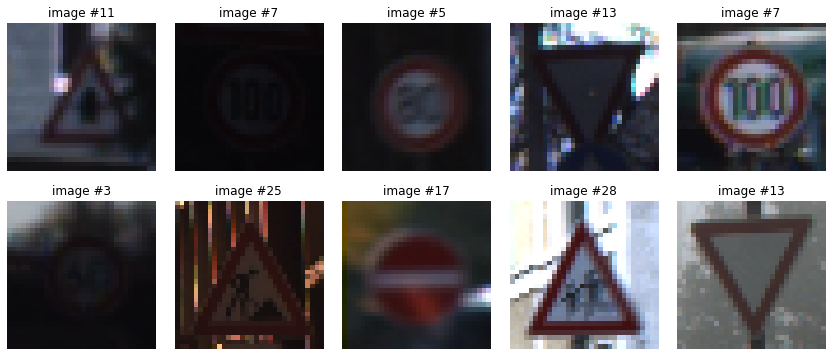

In [31]:
# setup figure to show images; 2 rows, 5 cols
fig, axs = plt.subplots(2,5, figsize=(15, 6))
# setup spaces between images
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

## show  10 random images
# ToDo: assure to don't chose same image twice
for i in range(10):
    # take index randomly chosen
    index = random.randint(0, len(X_train))
    # choose the image according to the index
    image = X_train[index]
    axs[i].axis('off')
    # show the image
    axs[i].imshow(image)
    # give a meaningful title
    axs[i].set_title('image #' + str(y_train[index]))

## Imbalanced dataset

The bar chart shows the frequency distribution of traffic sign respect to the classes.
 
* Some classes are much more frequent than others.
* This shows we are dealing with an imbalanced dataset.
* This may be a problem.




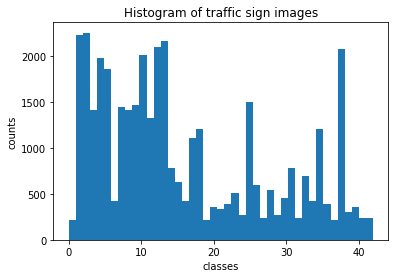

In [32]:
## plot histogram
fig, ax = plt.subplots()
# array with evenly spaced classes
ind = np.arange(n_classes)

# histogram
n, bins, patches = ax.hist(y_train, n_classes)
# horizontal axis label
ax.set_xlabel('classes')
# vertical axis label
ax.set_ylabel('counts')
# plot title
ax.set_title(r'Histogram of traffic sign images')
# show plot
plt.show()

----

## Step 2: Data Preparation




We first convert the images in grayscale so to simplify the problem. 

(39209, 32, 32, 3)
(39209, 32, 32)
(12630, 32, 32, 3)
(12630, 32, 32)


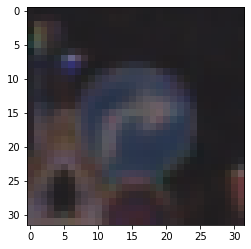

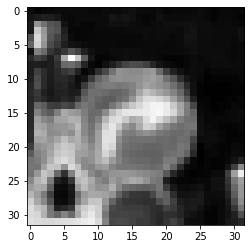

In [33]:
# convert to grayscale
X_traingray = setgrayscale(X_train)
X_testgray = setgrayscale(X_test)

# random index
index = random.randint(0, len(X_traingray))

#original image
image = X_train[index]
plt.figure(figsize=(4,4))
plt.imshow(image)

#grayscale
image = X_traingray[index]
plt.figure(figsize=(4,4))
plt.imshow(image,cmap="Greys_r")

The images have also been normalized to avoid numerical problems


We select only three classes and down-sample the dataset to reduce inference computational time.

In [34]:
np.random.seed(0)
#classes = [1, 2, 4]
classes = [3, 7, 9]
N_per_class =500

X = []
labels = []
for d in classes:
    imgs = X_traingray[np.where(y_train==d)[0],:]
    X.append(imgs[np.random.permutation(imgs.shape[0]),:][0:N_per_class,:])
    labels.append(np.ones(N_per_class)*d)
X_traingray2 = np.vstack(X).astype(np.float64)
y_train2 = np.hstack(labels)

In [35]:
print(X_traingray2.shape,y_train2.shape)

(1500, 32, 32) (1500,)


In [36]:
### we split the dataset in training and validation
X_tr, X_val, y_tr, y_val = train_test_split(X_traingray2, y_train2, test_size=0.2, random_state=0)
 

X_tr, y_tr = shuffle(X_tr, y_tr)

print(X_tr.shape)
print(X_val.shape)
print(y_tr.shape)
print(y_val.shape)

(1200, 32, 32)
(300, 32, 32)
(1200,)
(300,)


In [37]:
# transform images into vectors  
X_trv = X_tr.flatten().reshape(X_tr.shape[0],X_tr.shape[1]*X_tr.shape[2])
X_valv = X_val.flatten().reshape(X_val.shape[0],X_tr.shape[1]*X_tr.shape[2])
print(X_trv.shape)
print(X_valv.shape)
print(y_tr.shape)
print(y_val.shape)

(1200, 1024)
(300, 1024)
(1200,)
(300,)


## Step 3: Algorithm

There are various aspects to consider when thinking about this problem:

- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- data augmentation to increase the dataset.

For now, we are not interested in obtaining the highest performance, but more in understanding the various approaches.

We define our "general recipe" machine learning model: logistic regression

In [38]:
#General-recipe ML logistic regression
clf = LogisticRegression(random_state=0, max_iter=2000, C=100, solver='lbfgs', multi_class='multinomial').fit(X_trv, y_tr)
y_pred_logi = clf.predict(X_valv)
y_pred_logi_prob = clf.predict_proba(X_valv)
prob_classmax = np.max(y_pred_logi_prob,axis=1)
print("Accuracy=", accuracy_score(y_pred_logi,y_val))

Accuracy= 0.95


In [39]:
np.sort(prob_classmax)

array([0.46509636, 0.50320445, 0.51018699, 0.5214304 , 0.57707832,
       0.60260064, 0.60662391, 0.63134605, 0.67052598, 0.6897771 ,
       0.7249869 , 0.77612899, 0.79148316, 0.79437621, 0.79809087,
       0.79893907, 0.80132317, 0.8109172 , 0.84195948, 0.84411404,
       0.84415532, 0.85209927, 0.87221239, 0.87584782, 0.88547771,
       0.8894656 , 0.89071639, 0.89075437, 0.89966005, 0.90262429,
       0.90410243, 0.91200074, 0.93286773, 0.93565699, 0.93804463,
       0.93994493, 0.93995121, 0.94705482, 0.94853045, 0.94940783,
       0.95144529, 0.95831392, 0.9587318 , 0.96485645, 0.9663552 ,
       0.97086099, 0.97222764, 0.97272933, 0.97357117, 0.97989141,
       0.98079133, 0.98242627, 0.98559091, 0.98654941, 0.98693095,
       0.98727507, 0.98783634, 0.98988879, 0.98996283, 0.99035372,
       0.99077243, 0.99095625, 0.99141171, 0.99210665, 0.99362712,
       0.99420456, 0.99424579, 0.99428833, 0.99458726, 0.99464082,
       0.99482193, 0.99524772, 0.99546057, 0.99559655, 0.99584

In [40]:
# probability of general-recipe logistic regression in wrong instances
prob_classmax[y_pred_logi!=y_val]

array([0.98988879, 0.46509636, 0.60662391, 0.93565699, 0.94705482,
       0.99996653, 0.99920728, 0.93995121, 0.93804463, 0.77612899,
       0.51018699, 0.99901347, 0.8109172 , 0.79809087, 0.7249869 ])

it performs quite well

In [41]:
np.array(y_pred_logi)

array([3., 3., 9., 3., 9., 9., 7., 3., 3., 9., 9., 9., 9., 3., 7., 7., 9.,
       9., 3., 9., 3., 7., 3., 3., 9., 7., 9., 7., 7., 9., 9., 3., 9., 7.,
       3., 9., 3., 7., 3., 3., 9., 9., 9., 3., 3., 7., 9., 7., 7., 9., 7.,
       9., 7., 9., 7., 9., 7., 7., 9., 9., 3., 3., 9., 3., 7., 7., 7., 9.,
       9., 9., 3., 3., 7., 3., 3., 7., 7., 3., 3., 9., 9., 3., 3., 3., 7.,
       3., 9., 3., 7., 3., 7., 7., 3., 3., 9., 9., 7., 7., 3., 7., 7., 9.,
       3., 7., 9., 7., 3., 3., 7., 9., 3., 3., 3., 3., 9., 7., 7., 9., 7.,
       7., 3., 7., 3., 7., 3., 7., 3., 3., 3., 7., 7., 7., 3., 9., 7., 3.,
       3., 9., 9., 7., 3., 7., 7., 7., 3., 3., 7., 3., 9., 3., 3., 9., 3.,
       7., 7., 7., 9., 3., 9., 7., 9., 7., 3., 9., 9., 7., 9., 9., 3., 3.,
       3., 7., 9., 3., 7., 3., 3., 7., 9., 7., 3., 3., 7., 3., 7., 3., 7.,
       3., 3., 3., 3., 9., 9., 3., 9., 3., 9., 3., 3., 3., 3., 3., 7., 3.,
       7., 3., 3., 3., 7., 7., 9., 7., 3., 9., 9., 3., 9., 7., 7., 9., 7.,
       3., 7., 7., 7., 3.

## Step 4: Probabilistic ML

In [42]:
import sklearn.preprocessing
## We use LabelBinarizer to transfor classes into counts
# neg_label=0, pos_label=1 
y_2_bin = sklearn.preprocessing.LabelBinarizer().fit_transform(y_tr.reshape(-1,1))
nf = X_trv.shape[1]
# number of classes
nc = len(classes)
# floatX = float32
floatX = tt.config.floatX

init_b = np.random.randn(nf, nc-1).astype(floatX)
init_a = np.random.randn(nc-1).astype(floatX)


with pm.Model() as multi_logistic:
    # Prior
    β = pm.Normal('beta', 0, sigma=100, shape=(nf, nc-1), testval=init_b)
    α = pm.Normal('alpha', 0, sigma=100, shape=(nc-1,), testval=init_a)
    
    # we need to consider nc-1 features because the model is not identifiable
    # the softmax turns a vector into a probability that sums up to one
    # therefore we add zeros to go back to dimension nc
    # so that softmax returns a vector of dimension nc
    β1  = tt.tensor.concatenate([np.zeros((nf,1)),β ],axis=1)
    α1  = tt.tensor.concatenate([[0],α ],)
    
    # Likelihood
    mu = pm.math.matrix_dot(X_trv,β1) + α1
    # It doesn't work if the problem is binary
    p = tt.tensor.nnet.nnet.softmax(mu)
    observed = pm.Multinomial('likelihood', p=p, n=1, observed=y_2_bin)

In [43]:
y_2_bin

array([[1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [44]:
with multi_logistic:
    #approx = pm.fit(300000, method='advi') # takes longer
    approx = pm.fit(3000, method='advi')

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Finished [100%]: Average Loss = 14,291


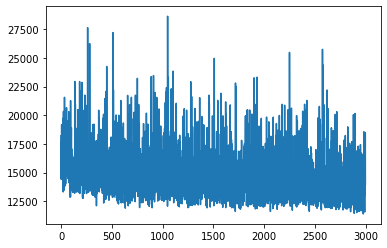

In [45]:
plt.plot(approx.hist)

In [46]:
dd = 300
posterior = approx.sample(draws=dd)

test image #10
posterior sample #100
true class= 9.0
classes: [3, 7, 9]
estimated prob= [0.27954595 0.55217654 0.16827751]


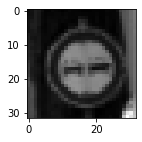

In [47]:
## The softmax function transforms each element of a collection by computing the exponential
#  of each element divided by the sum of the exponentials of all the elements.
from scipy.special import softmax

#select an image in the test set
i = 10 
#i = random.randint(0, dd)

#select a sample in the posterior
s = 100 
#s = random.randint(0, dd)


beta  = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
image = X_valv[i,:].reshape(32,32)
plt.figure(figsize=(2,2))
plt.imshow(image,cmap="Greys_r")
np.set_printoptions(suppress=True)

print("test image #" + str(i))
print("posterior sample #" + str(s))
print("true class=", y_val[i])
print("classes: " + str(classes))
print("estimated prob=",softmax((np.array([X_valv[i,:].dot(beta) + alpha])))[0,:])

In [48]:
# Bayesian prediction
# return the class that has the highest posterior probability
y_pred_Bayesian=[]

for i in range(X_valv.shape[0]):
    val=np.zeros((1,len(classes)))
    
    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])     
        val = val + softmax((np.array([X_valv[i,:].dot(beta) + alpha])))
    
    mean_probability = val/posterior['beta'].shape[0]
    y_pred_Bayesian.append( np.argmax(mean_probability))

In [49]:
print(y_pred_Bayesian)

[0, 2, 2, 2, 2, 0, 2, 0, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 0, 1, 2, 1, 2, 0, 2, 2, 2, 0, 2, 1, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 1, 0, 0, 1, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 1, 0, 2, 1, 0, 2, 1, 2, 2, 0, 2, 2, 0, 0, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 0, 1, 0, 2, 2, 0, 0, 2, 2, 1, 2, 1, 0, 2, 0, 1, 1, 2, 1, 0, 2, 1, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 2, 1, 2, 1, 2, 1, 2, 0, 2, 1, 2, 2, 2, 0, 2, 0, 1, 0, 0, 0, 2, 2, 0, 2, 2, 1, 2, 0, 2, 2, 0, 2, 1, 0, 2, 2, 1, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 1, 2, 0, 2, 2, 2, 0]


In [50]:
# recall the classes we are using
print(classes)

[3, 7, 9]


In [51]:
# prediction array (using classes)
nn = 10 # just an example
np.array(classes)[y_pred_Bayesian[0:nn]]

array([3, 9, 9, 9, 9, 3, 9, 3, 7, 9])

In [52]:
# using validation: y_val
print("Accuracy=", accuracy_score(np.array(classes)[y_pred_Bayesian], y_val))

Accuracy= 0.49333333333333335


## Selecting different instances

In [53]:
y_predB=[]

for i in range(X_valv.shape[0]):
    #print(i)
    val=[]

    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
        val.append(softmax((np.array([X_valv[i,:].dot(beta) + alpha])))[0,:])

    #mean probability
    valmean = np.mean(val,axis=0)
    #class with maximum mean probability
    classmax = np.argmax(valmean)
    #ranks
    ranks = np.array(val.copy())
    ranks   = ranks  *0 #init
    colmax = np.argmax(np.array(val),axis=1)
    ranks[np.arange(0,len(colmax)),colmax]=1
     
    y_predB.append( [classmax, valmean[classmax], np.std(ranks,axis=0)[classmax]])

    
y_predB= np.array(y_predB)

In [54]:
# prediction array
mm = 10
y_predB[0:mm,:]

array([[0.        , 0.48740975, 0.49781746],
       [2.        , 0.49351976, 0.5       ],
       [2.        , 0.59177618, 0.49121165],
       [2.        , 0.43688336, 0.49714742],
       [2.        , 0.54282789, 0.49714742],
       [0.        , 0.43696445, 0.49553562],
       [2.        , 0.42627868, 0.49638695],
       [0.        , 0.85803576, 0.32102267],
       [1.        , 0.38473986, 0.48774994],
       [2.        , 0.713833  , 0.4330127 ]])

In [55]:
#sorting in descending order
difficult = np.argsort(-y_predB[:,2])
y_predB[difficult[0:mm],:]

array([[1.        , 0.46228295, 0.5       ],
       [2.        , 0.49351976, 0.5       ],
       [2.        , 0.50832347, 0.5       ],
       [2.        , 0.49195801, 0.49998889],
       [2.        , 0.46494546, 0.49998889],
       [0.        , 0.50050585, 0.49998889],
       [1.        , 0.49791229, 0.49998889],
       [2.        , 0.48964104, 0.49998889],
       [2.        , 0.4825175 , 0.49995555],
       [2.        , 0.48178405, 0.49995555]])

In [56]:
#probability of general-recipe logistic regression in wrong instances
prob_classmax[y_pred_logi != y_val]

array([0.98988879, 0.46509636, 0.60662391, 0.93565699, 0.94705482,
       0.99996653, 0.99920728, 0.93995121, 0.93804463, 0.77612899,
       0.51018699, 0.99901347, 0.8109172 , 0.79809087, 0.7249869 ])

In [57]:
y_predB[y_pred_logi != y_val,:]

array([[0.        , 0.58395673, 0.48848974],
       [0.        , 0.41707271, 0.49909919],
       [2.        , 0.58402186, 0.49183331],
       [2.        , 0.49351554, 0.49995555],
       [0.        , 0.65171308, 0.47370877],
       [0.        , 0.41026566, 0.49183331],
       [0.        , 0.63116905, 0.48095969],
       [1.        , 0.47866562, 0.49995555],
       [0.        , 0.66701577, 0.46249324],
       [2.        , 0.51078501, 0.49989999],
       [0.        , 0.60259743, 0.4869862 ],
       [0.        , 0.57939606, 0.49300665],
       [0.        , 0.45394927, 0.49714742],
       [1.        , 0.63545633, 0.47590849],
       [1.        , 0.36450717, 0.4769696 ]])

In [58]:
## Difficult & easy instances

easy = np.argsort(y_predB[:,2])
print("Accuracy in easy instances =", accuracy_score(y_pred_logi[easy[0:100]], y_val[easy[0:100]]))

difficult = np.argsort(-y_predB[:,2])
print("Accuracy in difficult instances =", accuracy_score(y_pred_logi[difficult[0:100]], y_val[difficult[0:100]]))

Accuracy in easy instances = 0.94
Accuracy in difficult instances = 0.96


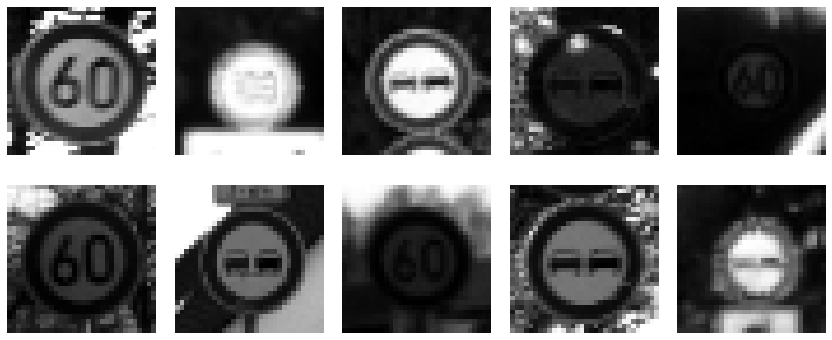

In [59]:
# show 10 random 'easy' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in range(10):
    index = easy[i]
    image = X_valv[index,:].reshape(32,32)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")

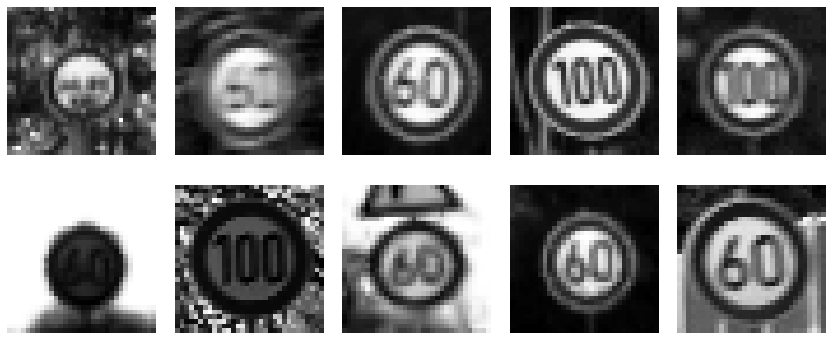

In [60]:

# show 10 random 'difficult' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = difficult[i]
    image = X_valv[index,:].reshape(32,32)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")    